<a href="https://colab.research.google.com/github/SwayamParida/handwritten-math-exp-recognition/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import os
from collections import defaultdict
from PIL import Image
from skimage import feature
from sklearn import linear_model, model_selection, preprocessing
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, utils
from torchvision import datasets, models, transforms

plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline

## Atomic Symbol Dataset

The atomic symbol dataset is contained in the directory referenced by the relative filepath stored in `ATOMIC_SYMBOL_DATASET_DIR`. The dataset contains a subdirectory per math symbol with the directory name corresponding to the symbol name. Each subdirectory contains JPG images of the handwritten symbols that serve as training examples for that symbol class.

In [0]:
%cd drive/My\ Drive/cs231n/project/data
!cp data.zip /content/
%cd /content/
!unzip -nq data.zip

In [0]:
ATOMIC_SYMBOL_DATASET_DIR = '/content/extracted_images'

In [0]:
symbol_dataset = datasets.ImageFolder(ATOMIC_SYMBOL_DATASET_DIR, transform=transforms.ToTensor())

Getting a feel for the dataset

Symbol: f
Image dimensions: (45, 45)


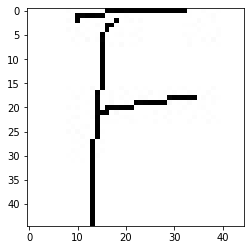

In [5]:
random_index = np.random.choice(len(symbol_dataset))
sample_img, sample_img_label = symbol_dataset[random_index]
sample_img_label = symbol_dataset.classes[sample_img_label]
_ = plt.imshow(sample_img, cmap='Greys_r')
print(f'Symbol: {sample_img_label}')
print(f'Image dimensions: {sample_img.size}')

In [6]:
print(f'Number of examples: {len(symbol_dataset)}')
print(f'Number of classes: {len(symbol_dataset.classes)}')

Number of examples: 375974
Number of classes: 82


Distribution of labels in the dataset

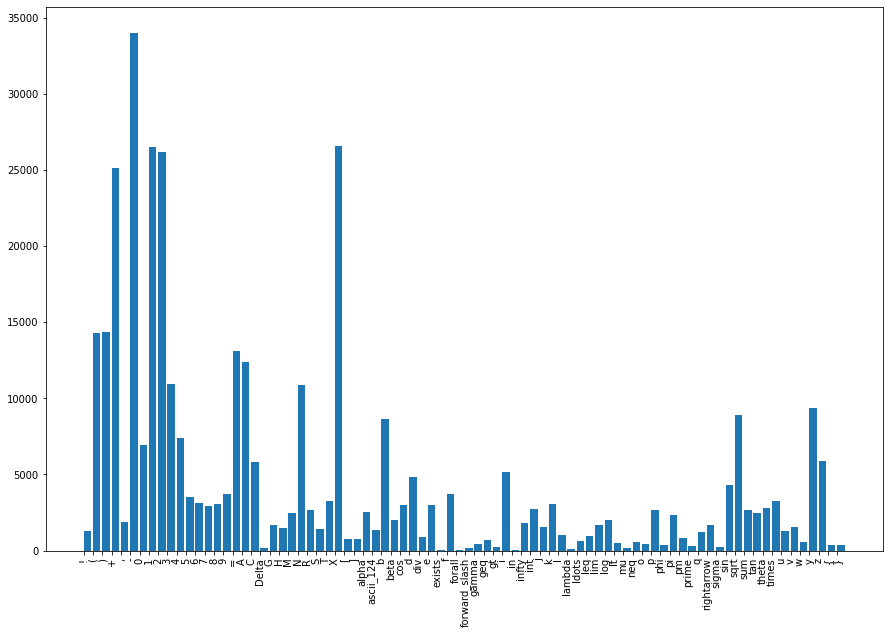

In [7]:
label_indices, label_counts = np.unique(symbol_dataset.targets, return_counts=True)
idx_to_class = {idx: label for (label, idx) in symbol_dataset.class_to_idx.items()}
plt.figure(figsize=[15, 10])
_ = plt.bar(np.arange(len(label_indices)), label_counts, align='edge',
            tick_label=[idx_to_class[idx] for idx in label_indices]
           )
_ = plt.xticks(rotation=90)

# Baseline 1 - Symbol Segmentation and Atomic Classification

To establish a baseline for the classification task, we shall develop a rudimentary model that segments each image of a mathematical expression into individual symbols and then feed these symbols to a Softmax classifer that has been trained on the atomic symbols dataset.

Segmenting expressions into individual symbols

In [0]:
def featurize(X, featurizers=None):
  X_feat = []
  for ex in X:
    if featurizers is None:
      x = np.ndarray.flatten(ex)
    else:
      x = np.concatenate([np.ndarray.flatten(featurizer(ex)) for featurizer in featurizers])
    X_feat.append(x)
  return np.array(X_feat)

Converting PyTorch Dataset object into Numpy arrays

In [12]:
data_loader = utils.data.DataLoader(symbol_dataset, batch_size=len(symbol_dataset), num_workers=4)
X, y = next(iter(data_loader))
X, y = x.numpy(), y.numpy()

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

RuntimeError: ignored

Training a Softmax classifier on the raw pixels of the atomic symbols dataset

In [0]:
softmax_classifier = linear_model.LogisticRegression()
X_train_feat = featurize(X_train)
softmax_classifier.fit(X_train_feat, y_train)

train_acc = softmax_classifier.score(X_train_feat, y_train)
test_acc = softmax_classifier.score(featurize(X_test), y_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Training the classifier with DAISY feature descriptors instead of raw pixels

In [0]:
X_train_feat = featurize(X_train, [feature.daisy])
softmax_classifier.fit(featurize(X_train_feat), y_train)

train_acc = softmax_classifier.score(X_train_feat, y_train)
test_acc = softmax_classifier.score(featurize(X_test, [feature.daisy]), y_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Using AlexNet as a feature extractor

In [44]:
model_ft = models.alexnet(pretrained=True)

for param in model_ft.parameters():
  param.requires_grad = False
num_features = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_features, len(symbol_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

print(model_ft)

params_to_update = [param for param in model_ft.parameters() if param.requires_grad]
optimizer_ft = optim.Adam(params_to_update, lr=1e-3)
loss_func = nn.CrossEntropyLoss()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Perform image transformations so that dataset images fit AlexNet configurations

In [0]:
tsfm = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

symbol_dataset = datasets.ImageFolder(ATOMIC_SYMBOL_DATASET_DIR, transform=tsfm)

Splitting dataset into train and test sets

In [0]:
test_train_split = [0.8, 0.2]
assert(np.sum(test_train_split) == 1.0)

split_lengths = np.round(np.multiply(test_train_split, len(symbol_dataset)))
split_lengths = split_lengths.astype(int)
assert(np.sum(split_lengths) == len(symbol_dataset))

train_set, test_set = utils.data.random_split(symbol_dataset, split_lengths)
train_loader = utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=4)

Training a Softmax Layer with AlexNet features

In [48]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer_ft.zero_grad()

        # forward + backward + optimize
        outputs = model_ft(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.980
[1,  2000] loss: 0.848
[2,  1000] loss: 0.777
[2,  2000] loss: 0.745
Finished Training


Evaluating the model accuracy

In [52]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % 
        (100 * correct / total)
     )

Accuracy of the network on the 10000 test images: 77 %
